<a href="https://colab.research.google.com/github/Hari-Prannav/CodeChef-Task2-NLP/blob/main/CodeChef_Task_2_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
import kagglehub
import numpy as np

In [2]:
# Load Dataset

path = kagglehub.dataset_download("arjoonn/codechef-competitive-programming")
print("Path to dataset files:", path)

# Load 'questions.csv' (main problem statements dataset)
data_path = os.path.join(path, 'questions.csv')
df = pd.read_csv(data_path)
print("Loaded dataset successfully!")
print("Shape:", df.shape)
print("Columns:", df.columns)

100%|██████████| 265M/265M [00:13<00:00, 21.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/arjoonn/codechef-competitive-programming/versions/5
Loaded dataset successfully!
Shape: (1474, 13)
Columns: Index(['QCode', 'Title', 'link', 'level', 'statement', 'Author', 'Tester',
       'Editorial', 'Tags', 'Date Added', 'Time Limit', 'Source Limit',
       'Languages'],
      dtype='object')


In [3]:
# Keep and Clean Required Columns

df = df[['QCode', 'Title', 'statement', 'Tags']].copy()
df.dropna(subset=['statement'], inplace=True)
print("Cleaned dataset shape:", df.shape)

# Combine title + statement for better context
df["text"] = df["Title"].astype(str) + ". " + df["statement"].astype(str)

Cleaned dataset shape: (1474, 4)


In [4]:
# Generate Semantic Embeddings

from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(df["statement"].tolist(), show_progress_bar=True)

from sklearn.preprocessing import StandardScaler

embeddings_scaled = StandardScaler().fit_transform(embeddings)






/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

In [5]:
# Dimensionality Reduction (UMAP) & Clustering (HDBSCAN)

import umap
import hdbscan

reduced = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine').fit_transform(embeddings)
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=80,    # slightly smaller clusters allowed
    min_samples=10,         # less strict density requirement
    metric='euclidean'
)
labels = clusterer.fit_predict(reduced)
df["cluster"] = labels

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [6]:
# Cluster Analysis

for cluster_id in set(df["cluster"]):
    print(f"\n--- Cluster {cluster_id} ---")
    sample = df[df["cluster"] == cluster_id].sample(5, random_state=42)
    print(sample["Title"].to_list())


--- Cluster 0 ---
['Decompose the Tree', 'Tree Again', 'Chef and Tree', 'Chef and Girls', 'Sereja and Tree']

--- Cluster 1 ---
['Pattern matching', 'The Gray-Similar Code', 'Make Him Happy', 'Chef of The Ancient', 'Id and Ship']

--- Cluster -1 ---
['Children Trips', 'Little Elephant and Bubble Sort', 'Witua and Math', 'Sherlock and the Grid', 'Polo the Penguin and the Lucky String']


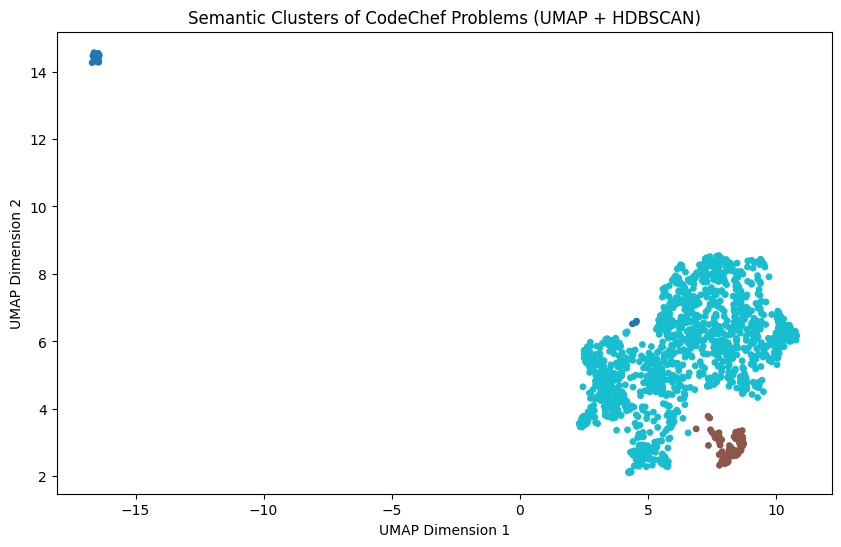

In [7]:
# Visualization

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap='tab10', s=15)
plt.title("Semantic Clusters of CodeChef Problems (UMAP + HDBSCAN)")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()


In [8]:
# Evaluation

from sklearn.metrics import silhouette_score

mask = labels != -1
print("Silhouette Score:", silhouette_score(reduced[mask], labels[mask]))

import numpy as np
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

Silhouette Score: 0.19835955
{np.int64(-1): np.int64(49), np.int64(0): np.int64(92), np.int64(1): np.int64(1333)}
